In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, Statistics, JLD2

┌ Warning: attempting to remove probably stale pidfile
│   path = "C:\\Users\\lisah\\.julia\\compiled\\v1.11\\enso_project\\bGV4d_goLnZ.ji.pidfile"
└ @ FileWatching.Pidfile C:\Users\lisah\AppData\Local\Programs\Julia-1.11.5\share\julia\stdlib\v1.11\FileWatching\src\pidfile.jl:249
[ Info: Precompiling enso_project [92f8d58f-31a9-439a-b05e-792ebdf1e7ff] (cache misses: include_dependency fsize change (4))
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10
┌ Warning: The use of `Flux.@functor` is deprecated.
│ Most likely, you should write `Flux.@layer MyLayer`which will add various convenience methods for your type,such as pretty-printing and use with Adapt.jl.
│ However, this is not required. Flux.jl v0.15 

## Perform error analysis on MJO predictions

### prepare data

In [ ]:
# load data
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"];

# perform TDE
D1, τ1 = enso_project.tde_with_negative_shift(pc1)
D2, τ2 = enso_project.tde_with_negative_shift(pc2)
D1, D2 = D1', D2';

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [ ]:
# train, test, val splits
train_size = 10000
val_size = 2000
test_size = size(D1,2) - train_size - val_size

"train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]\nval_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]\ntest_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];"

In [ ]:
train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]
val_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]
test_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];

### gather prediction samples

In [ ]:
# sample size N
N = 200

# lead time L
L = 60

# check whether test set is large enough
test_size > N+L

true

### training

In [ ]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [ ]:
# pc1
predictions_pc1, datasets_test_pc1 = enso_project.sample_lead_times(L,N,D1, train_size, val_size,param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15044.143070206772
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14028.332117730697
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15049.769417189069
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14034.160924459913
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15055.31654451148
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14040.732893558747
Finished sample 3
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15061.288184875822
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14047.76253655364
Finished sample 4
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15068.150228201383
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14054.324592295316
Finished sample 5
enso_pr

([-0.27566749046206046 -0.4180764487501046 … 1.3414115528832302 1.0233338669390457; -0.40804194034149066 -0.5183064150309199 … 1.0463184013590061 0.677434514003485; … ; -0.8199345034698879 -0.8493218854015173 … -0.5639773419020027 -0.619423176003913; -0.8972456695979706 -0.983082569286481 … -0.6119189676569883 -0.6456070029656537], [-0.26594 -0.4044 … 1.12644 0.92548; -0.4044 -0.48163 … 0.92548 0.70306; … ; -0.84672 -0.88283 … -0.61283 -0.66758; -0.88283 -0.96105 … -0.66758 -0.69889])

In [65]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc1.csv", DataFrame(predictions_pc1, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc1.csv", DataFrame(datasets_test_pc1, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L60_N400_testsets_pc1.csv"

In [ ]:
# pc2
predictions_pc2, datasets_test_pc2 = enso_project.sample_lead_times(L,N,D2, train_size, val_size,param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11115.251050486528
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 0.0)
Validation loss = 10150.310260075872
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 1.0e-5)
Validation loss = 10149.500738107126
Finished sample 1
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11124.885633472732
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 0.0)
Validation loss = 10159.360274590355
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 1.0e-5)
Validation loss = 10158.5631238539
Finished sample 2
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11134.786313250788
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 0.0)
Validation loss = 10168.367047501011
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 1.0e-5)
Validation loss = 10167.57497673299
Finished sample 3
enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11144.757477298623
enso_project.ESNHyperparams(60

([0.2948930158497483 0.40591836317099056 … 1.1493964487034611 1.454129786212392; 0.36740172269050386 0.49305602726392295 … 1.1782623216422912 1.4545432581143054; … ; 0.8050451422760325 0.5986298171216087 … 0.6201360986435484 0.34479798856004984; 0.6035400149017279 0.40479760173500595 … 0.3343984695862388 0.08537336681001544], [0.26534 0.36134 … 1.24953 1.41313; 0.36134 0.49521 … 1.41313 1.52727; … ; 0.8069 0.62408 … 0.87894 0.62425; 0.62408 0.47448 … 0.62425 0.36244])

In [67]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc2.csv", DataFrame(predictions_pc2, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc2.csv", DataFrame(datasets_test_pc2, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L60_N400_testsets_pc2.csv"

### error analysis

In [7]:
predictions_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc1.csv", DataFrame))
datasets_test_pc1 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc1.csv", DataFrame));

predictions_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_predictions_pc2.csv", DataFrame))
datasets_test_pc2 = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/error_saves/mjo_L$(L)_N$(N)_testsets_pc2.csv", DataFrame));

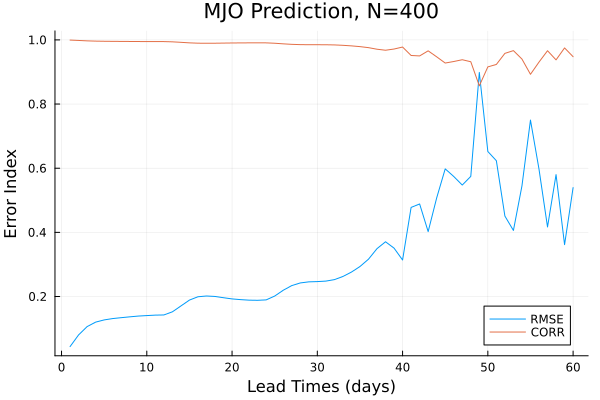

In [ ]:
rmse_vals = enso_project.rmse(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
corr_vals = enso_project.bivariate_corr(predictions_pc1, datasets_test_pc1, predictions_pc2, datasets_test_pc2)
plot(rmse_vals, label="RMSE", xlabel="Lead Times (days)", ylabel="Error Index", title="MJO Prediction, N=400")
plot!(corr_vals,label="CORR")
#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error.png")

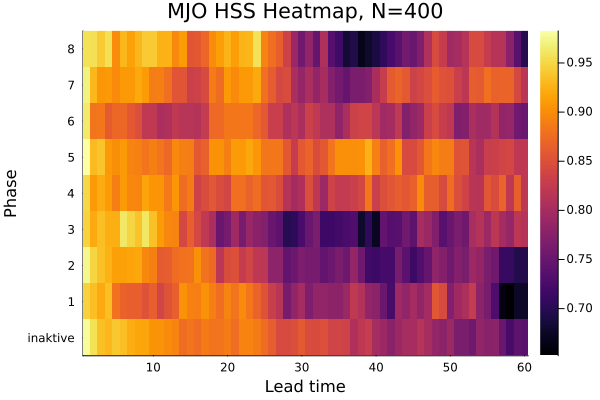

In [ ]:
hss_vals = enso_project.hss(predictions_pc1,predictions_pc2,datasets_test_pc1, datasets_test_pc2)

heatmap(hss_vals,
    #color=:viridis,   # choose your colormap
    title="MJO HSS Heatmap, N=400",
    xlabel="Lead time",
    ylabel="Phase",
    na_color=:white,   # color for NaN values
    yticks=(1:9, ["inaktive","1","2","3","4","5","6","7","8"])
)

#savefig("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/fig_saves/mjo_error_hss.png")